<b> Importing Libraries </b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import math

<b> Importing Data from Excel </b>

In [2]:
input_table=pd.read_excel('Input Sheet.xlsx')
input_table["Stream Type"]=np.where(input_table["Supply Temperture (°C)"]>input_table["Target Temperature (°C)"],"HOT","COLD")
input_table["Heat Capacity Flowrate (kW/K)"]=round(input_table["Heat Load (kW)"]/(input_table["Target Temperature (°C)"]-input_table["Supply Temperture (°C)"]),2)
#Heat Capacity Flowrate values of all hot streams have been made negative. This convention will be used later to simplify calculations for problem table algorithm.
index=[]
for n in range(1,len(input_table)+1):
    index.append(n)
input_table["Stream Number"]=index
input_table=input_table.set_index('Stream Number')
input_table

,Stream Information,Supply Temperture (°C),Target Temperature (°C),Heat Load (kW),Stream Type,Heat Capacity Flowrate (kW/K)
Stream Number,,,,,,
1,Stream 1,170,130,60,HOT,-1.5
2,Stream 2,160,100,180,HOT,-3.0
3,Stream 3,80,140,240,COLD,4.0


In [3]:
input_table=input_table.rename(columns={"Supply Temperture (°C)": "Ts", "Target Temperature (°C)": "Tt", "Heat Capacity Flowrate (kW/K)":"FCp"})

In [4]:
hot_streams=input_table[input_table["Stream Type"]=="HOT"]
cold_streams=input_table[input_table["Stream Type"]=="COLD"]

<b> Prompting the user to enter ΔTmin </b>

In [5]:
Tmin=float(input("Enter your ΔTmin (°C):"))

Enter your ΔTmin (°C):20


In [6]:
temp_left=cold_streams["Ts"].append(cold_streams["Tt"]).append(round((hot_streams["Ts"]-Tmin),2)).append(round((hot_streams["Tt"]-Tmin),2)).sort_values(ascending=False) 
temp_left=list(dict.fromkeys(temp_left)) #this will drop duplicates
temp_right=hot_streams["Ts"].append(hot_streams["Tt"]).append(round((cold_streams["Ts"]+Tmin),2)).append(round((cold_streams["Tt"]+Tmin),2)).sort_values(ascending=False) 
temp_right=list(dict.fromkeys(temp_right)) #this will drop duplicates

In [7]:
problem_table=pd.DataFrame()
problem_table["Network"]=[i for i in range(len(temp_left))]
problem_table["Network"]=problem_table["Network"].astype(str)
problem_table["Sub"]=np.repeat("SN",len(temp_left))
problem_table['Subnetwork'] = problem_table['Sub']+problem_table["Network"]
problem_table=problem_table.drop(["Sub","Network"],axis=1)
problem_table["Tleft"]=temp_left
problem_table["Tright"]=temp_right

<b> Defining a function to generate Temperature Interval Diagram </b>

In [8]:
def Temperature_Interval_Diagram():
    plt.figure(figsize=(20,20))
    plt.xlim(0,len(input_table.index)+1)
    plt.ylim(min(0.9*problem_table["Tleft"].min(),1.1*problem_table["Tleft"].min()),max(1.1*problem_table["Tleft"].max(),0.9*problem_table["Tleft"].max()))
    for stream_number,Ts,Tt,stream_name in zip(range(len(cold_streams)),cold_streams["Ts"],cold_streams["Tt"],cold_streams.index):
        plt.arrow(stream_number+1,Ts,0,Tt-Ts,length_includes_head=True,head_length=1.0,head_width=0.1)
        plt.axhline(Ts,color='black',lw=0.5,linestyle='dashed')
        plt.axhline(Tt,color='black',lw=0.5,linestyle='dashed')
        plt.text(stream_number+1,min(0.9*problem_table["Tleft"].min(),1.1*problem_table["Tleft"].min()),stream_name,fontsize=15)
    for stream_number,Ts,Tt,stream_name in zip(range(len(cold_streams),len(cold_streams)+len(hot_streams)),hot_streams["Ts"],hot_streams["Tt"],hot_streams.index):
        plt.arrow(stream_number+1,Ts-Tmin,0,Tt-Ts,length_includes_head=True,head_length=1.0,head_width=0.1)
        plt.axhline(Ts-Tmin,color='black',lw=0.5,linestyle='dashed')
        plt.axhline(Tt-Tmin,color='black',lw=0.5,linestyle='dashed')
        plt.text(stream_number+1,min(0.9*problem_table["Tleft"].min(),1.1*problem_table["Tleft"].min()),stream_name,fontsize=15)
    plt.axvline(len(cold_streams)+0.5,color='red',lw=0.5)
    for j in problem_table["Tleft"]:
        plt.text(len(cold_streams)+0.5,j,j,ha='right')
        plt.text(len(cold_streams)+0.5,j,j+Tmin)
    plt.xticks([])
    plt.yticks([])
    plt.title('Temperature Interval Diagram',fontsize=40)
    plt.savefig('Temperature Interval Diagram.png', dpi=300, bbox_inches='tight')
    plt.show()

In [9]:
streams_involved=np.zeros((len(problem_table),len(input_table)+1),dtype='int')
cold_streams_involved_1=np.zeros((len(problem_table),len(input_table)+1),dtype='int')
hot_streams_involved_1=np.zeros((len(problem_table),len(input_table)+1),dtype='int')
for i in range(len(problem_table)):
    for j in range(len(cold_streams)):
        cold_streams_involved=np.where(cold_streams.iloc[j]["Ts"]<=problem_table.iloc[i]["Tleft"]<cold_streams.iloc[j]["Tt"],cold_streams.iloc[j].name,0)
        streams_involved[i][cold_streams_involved]=cold_streams_involved
        cold_streams_involved_1[i][cold_streams_involved]=cold_streams_involved
    for k in range(len(hot_streams)):
        hot_streams_involved=np.where(hot_streams.iloc[k]["Tt"]<=problem_table.iloc[i]["Tright"]<hot_streams.iloc[k]["Ts"],hot_streams.iloc[k].name,0)
        streams_involved[i][hot_streams_involved]=hot_streams_involved
        hot_streams_involved_1[i][hot_streams_involved]=hot_streams_involved

In [10]:
problem_table["Streams Involved"]=[streams_involved[i] for i in range(len(problem_table))] 

In [11]:
difference=[0]
for i in range(1,len(problem_table)):
    difference.append(problem_table["Tleft"][i-1]-problem_table["Tleft"][i])
problem_table["Temperature Difference"]=difference

In [12]:
k=np.zeros(len(problem_table))
for i in range(len(problem_table)):
    streams=np.extract(problem_table["Streams Involved"][i]!=0, problem_table["Streams Involved"][i]) 
    sum_1=0#this is done so that there isn't error in the future
    n=len(streams)
    for n in range(len(streams)):
        sum_1=sum_1+input_table.loc[streams[n]]["FCp"] 
    k[i]=sum_1

In [13]:
problem_table["Summation of FCp"]=k
problem_table["Deficit"]=problem_table["Summation of FCp"]*problem_table["Temperature Difference"]
x=[-problem_table["Deficit"].cumsum()[i-1] for i in range(1,len(problem_table))]
x=np.array(x)
y=[0]
y=np.array(y)
z=np.concatenate((y,x))
problem_table["Accumulated Input"]=z 
problem_table["Accumulated Output"]=-problem_table["Deficit"].cumsum() 
problem_table["Heat Flows Input"]=abs(problem_table["Accumulated Output"].min())+problem_table["Accumulated Input"] 
problem_table["Heat Flows Output"]=abs(problem_table["Accumulated Output"].min())+problem_table["Accumulated Output"] 

In [14]:
pinch_temp=problem_table[problem_table["Heat Flows Output"]==0.0]["Tright"]
pinch_temp=pinch_temp.values
pinch_temp=pinch_temp[0]
minimum_hot_utility=problem_table.iloc[0]["Heat Flows Input"] 
minimum_cold_utility=problem_table.iloc[-1]["Heat Flows Output"] 

In [15]:
hot_composite_curve=pd.DataFrame()
hot_composite_curve["Temperature"]=problem_table["Tright"].values[::-1]
hot_composite_curve["Streams Involved"]=[hot_streams_involved_1[len(hot_streams_involved_1)-i-1] for i in range(len(hot_streams_involved_1))]
k=np.zeros(len(problem_table))
for i in range(len(problem_table)):
    streams=np.extract(hot_composite_curve["Streams Involved"][i]!=0, hot_composite_curve["Streams Involved"][i]) 
    sum_2=0
    n=len(streams)
    for n in range(len(streams)):
        sum_2=sum_2+input_table.loc[streams[n]]["FCp"] 
    k[i]=sum_2
hot_composite_curve["Summation of FCp"]=k
hot_composite_curve["Difference"]=problem_table["Temperature Difference"].values[::-1]
hot_composite_curve["Enthalpy not Final"]=hot_composite_curve["Difference"]*hot_composite_curve["Summation of FCp"]
hot_composite_curve["Enthalpy not Final Cumulative"]=hot_composite_curve["Enthalpy not Final"].cumsum()
final_enthalpy_hot_streams=np.concatenate((0, abs(hot_composite_curve["Enthalpy not Final Cumulative"]).values[:-1]), axis=None)
x=np.array(final_enthalpy_hot_streams,dtype=np.float)
y=np.array(hot_composite_curve["Temperature"],dtype=np.float)
hot_streams; z=hot_streams["Ts"].append(hot_streams["Tt"])
temp_values_of_hot_streams=np.array(z)
hot_composite_curve=pd.DataFrame()
hot_composite_curve["Temperature"]=y
hot_composite_curve["Final Enthalpy"]=x
hot_composite_curve=hot_composite_curve[hot_composite_curve['Temperature'].isin(z)]

In [16]:
cold_composite_curve=pd.DataFrame()
cold_composite_curve["Temperature"]=problem_table["Tleft"].values[::-1]
cold_composite_curve["Streams Involved"]=[cold_streams_involved_1[len(cold_streams_involved_1)-i-1] for i in range(len(cold_streams_involved_1))]
k=np.zeros(len(problem_table))
for i in range(len(problem_table)):
    streams=np.extract(cold_composite_curve["Streams Involved"][i]!=0, cold_composite_curve["Streams Involved"][i]) 
    sum_3=0
    n=len(streams)
    for n in range(len(streams)):
        sum_3=sum_3+input_table.loc[streams[n]]["FCp"] 
    k[i]=sum_3
cold_composite_curve["Summation of FCp"]=k
cold_composite_curve["Difference"]=problem_table["Temperature Difference"].values[::-1]
cold_composite_curve["Enthalpy not Final"]=cold_composite_curve["Difference"]*cold_composite_curve["Summation of FCp"]
cold_composite_curve["Enthalpy not Final Cumulative"]=cold_composite_curve["Enthalpy not Final"].cumsum()
final_enthalpy_cold_streams=np.concatenate((0, abs(cold_composite_curve["Enthalpy not Final Cumulative"]).values[:-1]), axis=None)
a=np.array(final_enthalpy_cold_streams,dtype=np.float)
b=np.array(cold_composite_curve["Temperature"],dtype=np.float)
cold_streams; c=cold_streams["Ts"].append(cold_streams["Tt"])
temp_values_of_cold_streams=np.array(c)
cold_composite_curve=pd.DataFrame()
cold_composite_curve["Temperature"]=b
cold_composite_curve["Final Enthalpy"]=a+minimum_cold_utility
cold_composite_curve=cold_composite_curve[cold_composite_curve['Temperature'].isin(c)]

<b> Defining a function to plot Combined Composite Curve </b>

In [17]:
def Combined_Composite_Curve():
    plt.xlim(0,1.1*cold_composite_curve["Final Enthalpy"].max())
    plt.ylim(0,1.1*max(hot_composite_curve["Temperature"].max(),cold_composite_curve["Temperature"].max()))
    plt.plot(hot_composite_curve["Final Enthalpy"],hot_composite_curve["Temperature"],color='red',label='Hot Composite Curve')
    plt.plot(cold_composite_curve["Final Enthalpy"],cold_composite_curve["Temperature"],color='blue',label='Cold Composite Curve')
    plt.legend()
    plt.xlabel('Enthalpy (kW)')
    plt.ylabel('Temperature (°C)')
    plt.title('Combined Composite Curve',fontsize=20)
    plt.savefig('Combined Composite Curve.png', dpi=300, bbox_inches='tight')
    plt.show()

<b> Defining a function to plot Grand Composite Curve </b>

In [18]:
def Grand_Composite_Curve():
    plt.xlim(0,problem_table["Heat Flows Output"].max()+10)
    plt.ylim(0,problem_table["Tright"].max()+10)
    plt.plot(problem_table["Heat Flows Output"],problem_table["Tright"],color='blue',lw=2)
    plt.xlabel('Enthalpy(kW)')
    plt.ylabel('Temperature (°C)')
    plt.title('Grand Composite Curve',fontsize=20)
    plt.savefig('Grand Composite Curve.png', dpi=300, bbox_inches='tight')
    plt.show()

<b> Defining a function to plot pinch in the grid representation </b>

In [19]:
def Pinch_in_the_grid_representation():
    plt.figure(figsize=(30,10))
    plt.ylim(-1,len(input_table)-0.5)
    plt.xlim(max(input_table["Ts"].max(),input_table["Tt"].max())+Tmin+5,min(input_table["Ts"].min(),input_table["Tt"].min())-Tmin-5) #this will also invert the x-axis limits
    plt.axvline(pinch_temp,color='black',lw=0.5,linestyle='dashed')
    for i in range(len(cold_streams)):
        for j in range(len(cold_streams),len(cold_streams)+len(hot_streams)):
            plt.arrow(hot_streams.iloc[j-len(cold_streams)]["Ts"],j,hot_streams.iloc[j-len(cold_streams)]["Tt"]-hot_streams.iloc[j-len(cold_streams)]["Ts"],0,length_includes_head=True,head_length=1.0,head_width=0.1)
            supply_hot=hot_streams.iloc[j-len(cold_streams)]["Ts"]
            plt.text(hot_streams.iloc[j-len(cold_streams)]["Ts"],j,f"{supply_hot}°",ha='right',fontsize=25)
            target_hot=hot_streams.iloc[j-len(cold_streams)]["Tt"]
            plt.text(hot_streams.iloc[j-len(cold_streams)]["Tt"],j,f"{target_hot}°",fontsize=25,ha='right')
            FCp_hot=abs(hot_streams.iloc[j-len(cold_streams)]["FCp"])
            plt.text(hot_streams.iloc[j-len(cold_streams)]["Tt"]-5,j,f"FCp={FCp_hot}kW/K",fontsize=25,fontweight='bold')
            plt.arrow(cold_streams.iloc[i]["Ts"]+Tmin,i,cold_streams.iloc[i]["Tt"]-cold_streams.iloc[i]["Ts"],0,length_includes_head=True,head_length=1.0,head_width=0.1)
            supply_cold=cold_streams.iloc[i]["Ts"]
            plt.text(cold_streams.iloc[i]["Ts"]+Tmin,i,f"{supply_cold}°",fontsize=25,ha='right')
            target_cold=cold_streams.iloc[i]["Tt"]
            plt.text(cold_streams.iloc[i]["Tt"]+Tmin,i,f"{target_cold}°",fontsize=25,ha='right')
            FCp_cold=cold_streams.iloc[i]["FCp"]
            plt.text(cold_streams.iloc[i]["Ts"]+Tmin-5,i,f"FCp={FCp_cold}kW/K",fontsize=25,fontweight='bold') 
    plt.text(max(input_table["Ts"].max(),input_table["Tt"].max())+Tmin,-1,"Hot End",fontsize=20,fontweight='bold')
    plt.text(min(input_table["Ts"].min(),input_table["Tt"].min())-Tmin,-1,"Cold End",fontsize=20,ha="right",fontweight='bold')
    plt.text(pinch_temp,-1.5,"The pinch effectively divides the problem into two parts\n Heat exchange cannot take place from one end to another, otherwise there will be penalties",ha="center",fontsize=25) 
    plt.xticks([])
    plt.yticks([])
    plt.title('Pinch in the grid representation',fontsize=40)
    plt.savefig('Pinch in the grid representation.png', dpi=300, bbox_inches='tight')
    plt.show()

In [20]:
f = interpolate.interp1d(cold_composite_curve["Final Enthalpy"], cold_composite_curve["Temperature"],bounds_error=False)
g=interpolate.interp1d(hot_composite_curve["Final Enthalpy"], hot_composite_curve["Temperature"],bounds_error=False)

In [21]:
extra_temp_hot=g(cold_composite_curve["Final Enthalpy"]);extra_enthalpy_hot=cold_composite_curve["Final Enthalpy"].to_numpy()
extra_temp_cold=f(hot_composite_curve["Final Enthalpy"]);extra_enthalpy_cold=hot_composite_curve["Final Enthalpy"].to_numpy()

In [22]:
temp={"Temperature":extra_temp_hot,"Final Enthalpy":extra_enthalpy_hot}
temp2=pd.DataFrame(temp)
hot_composite_duplicate=pd.concat([hot_composite_curve,temp2])
hot_composite_duplicate=hot_composite_duplicate.drop_duplicates()
hot_composite_duplicate=hot_composite_duplicate.sort_values('Final Enthalpy', ascending=True)
hot_composite_duplicate=hot_composite_duplicate.reset_index(drop=True)

In [23]:
temp={"Temperature":extra_temp_cold,"Final Enthalpy":extra_enthalpy_cold}
temp2=pd.DataFrame(temp)
cold_composite_duplicate=pd.concat([cold_composite_curve,temp2])
cold_composite_duplicate=cold_composite_duplicate.drop_duplicates()
cold_composite_duplicate=cold_composite_duplicate.sort_values('Final Enthalpy', ascending=True)
cold_composite_duplicate=cold_composite_duplicate.reset_index(drop=True)

In [24]:
hot_composite_duplicate = hot_composite_duplicate.rename(columns={'Temperature': 'Temperature of Hot Streams','Final Enthalpy': 'Final Enthalpy of Hot Streams'})
cold_composite_duplicate = cold_composite_duplicate.rename(columns={'Temperature': 'Temperature of Cold Streams','Final Enthalpy':'Final Enthalpy of Cold Streams'})

In [25]:
minimum_area_calculation=pd.concat([hot_composite_duplicate,cold_composite_duplicate],axis=1)
minimum_area_calculation=minimum_area_calculation.drop(['Final Enthalpy of Hot Streams'],axis=1)
minimum_area_calculation=minimum_area_calculation.rename(columns={'Final Enthalpy of Cold Streams':'Final Enthalpy of either streams'})
minimum_area_calculation=minimum_area_calculation.dropna()

In [26]:
minimum_area_calculation=minimum_area_calculation.drop_duplicates(subset='Final Enthalpy of either streams')

<b>Outputs</b>

<b> Drawing the final Problem Table </b>

In [27]:
problem_table

,Subnetwork,Tleft,Tright,Streams Involved,Temperature Difference,Summation of FCp,Deficit,Accumulated Input,Accumulated Output,Heat Flows Input,Heat Flows Output
0,SN0,150.0,170.0,"[0, 0, 0, 0]",0.0,0.0,0.0,0.0,-0.0,0.0,0.0
1,SN1,140.0,160.0,"[0, 1, 0, 0]",10.0,-1.5,-15.0,-0.0,15.0,0.0,15.0
2,SN2,110.0,130.0,"[0, 1, 2, 3]",30.0,-0.5,-15.0,15.0,30.0,15.0,30.0
3,SN3,80.0,100.0,"[0, 0, 2, 3]",30.0,1.0,30.0,30.0,-0.0,30.0,0.0


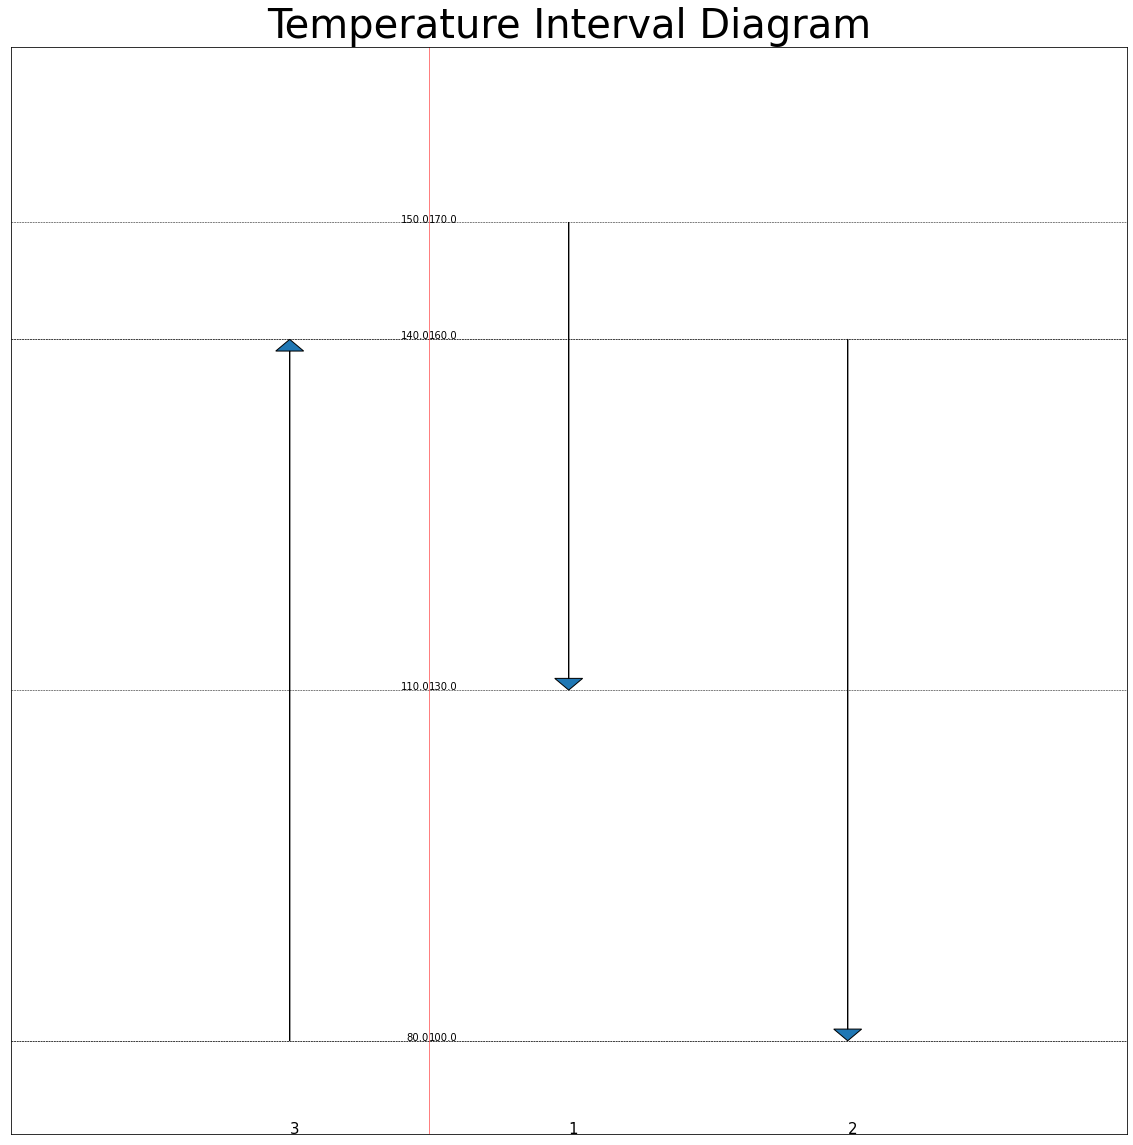

In [28]:
Temperature_Interval_Diagram()

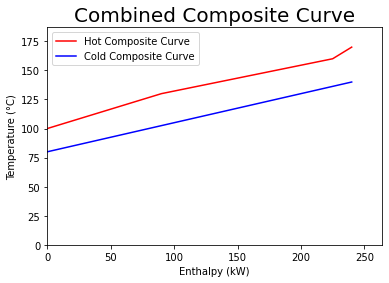

In [29]:
Combined_Composite_Curve()

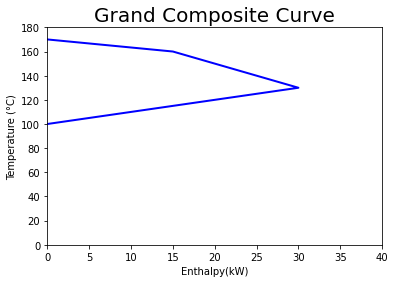

In [30]:
Grand_Composite_Curve()

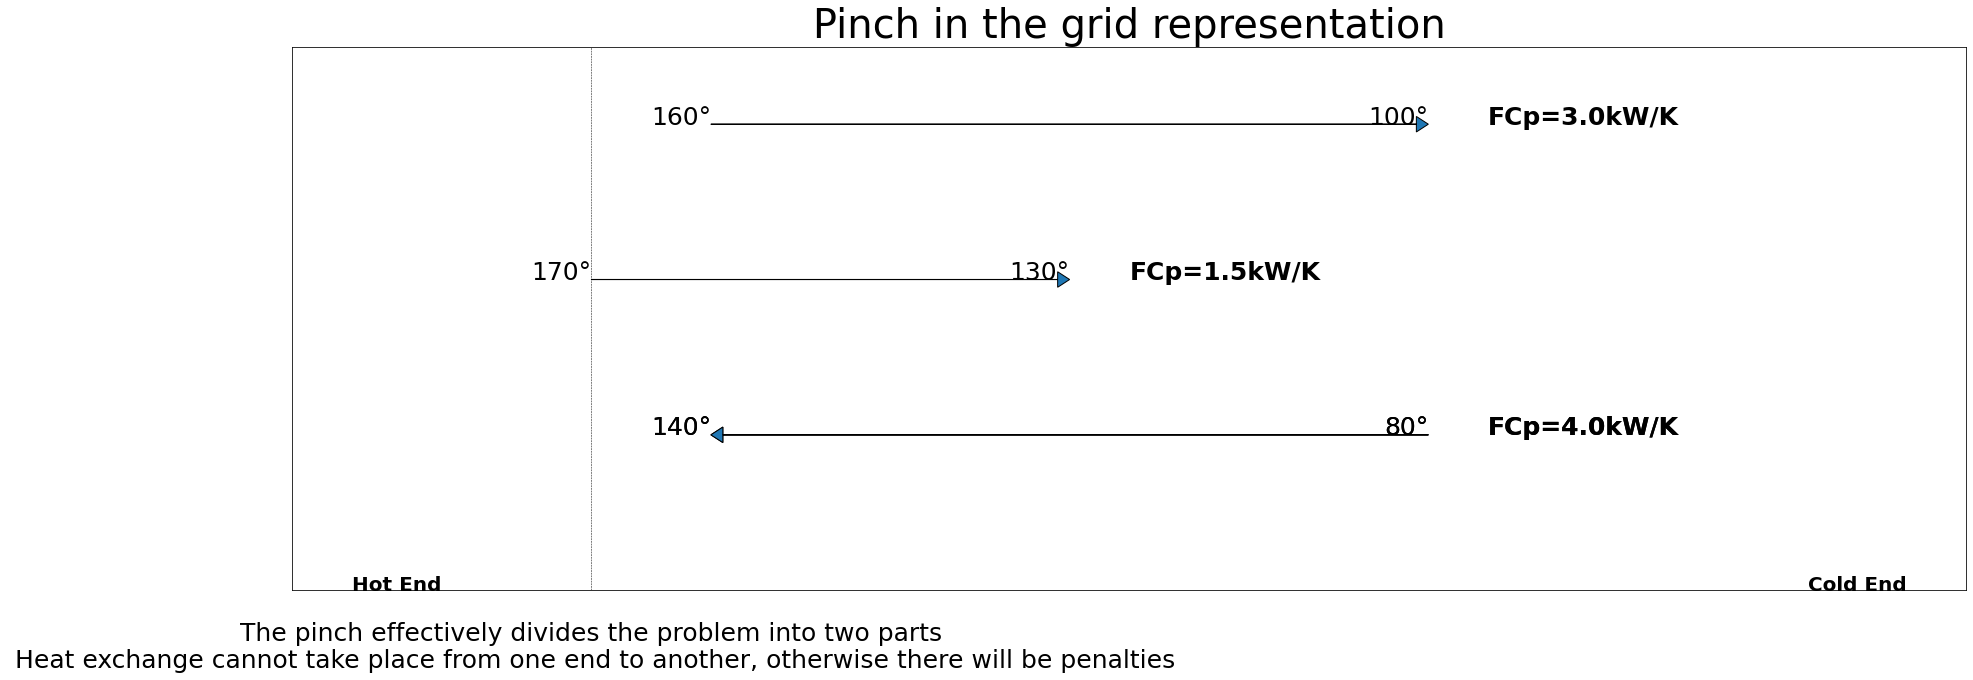

In [31]:
Pinch_in_the_grid_representation()

In [32]:
hot_composite_curve

,Temperature,Final Enthalpy
0,100.0,0.0
1,130.0,90.0
2,160.0,225.0
3,170.0,240.0


In [33]:
cold_composite_curve

,Temperature,Final Enthalpy
0,80.0,0.0
2,140.0,240.0


In [34]:
minimum_area_calculation

,Temperature of Hot Streams,Temperature of Cold Streams,Final Enthalpy of either streams
0,100.0,80.00,0.0
1,130.0,102.50,90.0
2,160.0,136.25,225.0
3,170.0,140.00,240.0


In [35]:
problem_table=problem_table.rename(columns={"Tleft": "Tleft (°C)", "Tright": "Tright (°C)", "Temperature Difference": "Temperature Difference (°C)", "Summation of FCp": "Summation of FCp (kW/K)", "Deficit":"Deficit (kW)",
                             "Accumulated Input":"Accumulated Input (kW)","Accumulated Output":"Accumulated Output (kW)","Heat Flows Input":"Heat Flows Input (kW)","Heat Flows Output":"Heat Flows Output (kW)"})

In [36]:
hot_composite_curve=hot_composite_curve.rename(columns={"Temperature":"Temperature of Hot Streams (°C)","Final Enthalpy":"Enthalpy (kW)"})
cold_composite_curve=cold_composite_curve.rename(columns={"Temperature":"Temperature of Cold Streams (°C)","Final Enthalpy":"Enthalpy (kW)"})
minimum_area_calculation=minimum_area_calculation.rename(columns={"Temperature of Hot Streams":"Temperature of Hot Streams (°C)","Temperature of Cold Streams":"Temperature of Cold Streams (°C)","Final Enthalpy of either streams":"Enthalpy (kW)"})

In [37]:
writer = pd.ExcelWriter('Design for Heat Exchanger Network.xlsx',engine='xlsxwriter')   
workbook=writer.book
worksheet=workbook.add_worksheet('Sheet 1')
writer.sheets['Sheet 1'] = worksheet
problem_table.to_excel(writer,sheet_name='Sheet 1',startrow=0 , startcol=0)   
hot_composite_curve.to_excel(writer,sheet_name='Sheet 1',startrow=len(problem_table)+1, startcol=0)
cold_composite_curve.to_excel(writer,sheet_name='Sheet 1',startrow=len(problem_table)+len(hot_composite_curve)+2, startcol=0)
minimum_area_calculation.to_excel(writer,sheet_name='Sheet 1',startrow=len(problem_table)+len(hot_composite_curve)+len(cold_composite_curve)+3, startcol=0)
writer.save()

In [38]:
import matplotlib.collections

In [42]:
def Final_Heat_Exchanger_Network():
    fig, ax = plt.subplots(figsize=(30,10))
    plt.ylim(-1,len(input_table)-0.5)
    plt.xlim(max(input_table["Ts"].max(),input_table["Tt"].max())+Tmin+5,min(input_table["Ts"].min(),input_table["Tt"].min())-Tmin-5) #this will also invert the x-axis limits
    plt.axvline(pinch_temp-17.5,color='black',lw=0.5,linestyle='dashed')
    for i in range(len(cold_streams)):
        for j in range(len(cold_streams),len(cold_streams)+len(hot_streams)):
            plt.arrow(hot_streams.iloc[j-len(cold_streams)]["Ts"]-18,j,(hot_streams.iloc[j-len(cold_streams)]["Tt"]-hot_streams.iloc[j-len(cold_streams)]["Ts"])+18,0,length_includes_head=True,head_length=1.0,head_width=0.1)
            supply_hot=hot_streams.iloc[j-len(cold_streams)]["Ts"]
            plt.text(hot_streams.iloc[j-len(cold_streams)]["Ts"]-18,j,f"{supply_hot}°",ha='right',fontsize=25)
            target_hot=hot_streams.iloc[j-len(cold_streams)]["Tt"]
            plt.text(hot_streams.iloc[j-len(cold_streams)]["Tt"],j,f"{target_hot}°",fontsize=25,ha='right')
            FCp_hot=abs(hot_streams.iloc[j-len(cold_streams)]["FCp"])
            plt.text(hot_streams.iloc[j-len(cold_streams)]["Tt"]-5,j,f"FCp={FCp_hot}kW/K",fontsize=25,fontweight='bold')
            plt.arrow(cold_streams.iloc[i]["Ts"]+Tmin,i,cold_streams.iloc[i]["Tt"]-cold_streams.iloc[i]["Ts"],0,length_includes_head=True,head_length=1.0,head_width=0.1)
            supply_cold=cold_streams.iloc[i]["Ts"]
            plt.text(cold_streams.iloc[i]["Ts"]+Tmin,i,f"{supply_cold}°",fontsize=25,ha='right')
            target_cold=cold_streams.iloc[i]["Tt"]
            plt.text(cold_streams.iloc[i]["Tt"]+Tmin,i,f"{target_cold}°",fontsize=25,ha='right')
            FCp_cold=cold_streams.iloc[i]["FCp"]
            plt.text(cold_streams.iloc[i]["Ts"]+Tmin-5,i,f"FCp={FCp_cold}kW/K",fontsize=25,fontweight='bold') 
    x_values=[130,134,138,142]
    y_values=[0,-0.33,-0.33,0]
    x_values_1=[105,105]
    y_values_1=[0,2]
    x_values_2=[137,137]
    y_values_2=[2,-0.33]
    x_values_3=[135,135]
    y_values_3=[0,1]
    x_values_4=[143,143]
    y_values_4=[0,1]
    plt.plot(x_values,y_values,color='black')
    plt.plot(x_values_1,y_values_1,color='black')
    plt.plot(x_values_2,y_values_2,color='black')
    plt.plot(x_values_3,y_values_3,color='black')
    plt.plot(x_values_4,y_values_4,color='black')
    xy=[[105,2],[105,0],[143,1],[143,0],[135,1],[135,0],[137,2],[137,-0.33]]
    radii=[0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25]
    facecolor=['red','red','blue','blue','green','green','yellow','yellow']
    patches = [plt.Circle(center,size) for center, size in zip(xy, radii)]
    coll = matplotlib.collections.PatchCollection(patches, facecolors=facecolor)
    ax.add_collection(coll)
    plt.text(105,2.3,"90",fontsize=17.5,ha='center')
    plt.text(105,-0.3,"90",fontsize=17.5,ha='center')
    plt.text(137,2.3,"90",fontsize=17.5,ha='center')
    plt.text(137,-0.8,"90",fontsize=17.5,ha='center')
    plt.text(135,1.3,"45",fontsize=17.5,ha='center')
    plt.text(135,0.3,"45",fontsize=17.5,ha='center')
    plt.text(143,1.3,"15",fontsize=17.5,ha='center')
    plt.text(143,0.3,"15",fontsize=17.5,ha='center')
    #plt.text()
    plt.text(130,2.3,"130°",fontsize=25,ha='center')
    plt.text(130,-0.6,"102.5°",fontsize=25,ha='center')
    plt.text(142,2.3,"160°",fontsize=25,ha='center')
    plt.text(142,-0.6,"136.25°",fontsize=25,ha='center')
    plt.axvline(x=130,color='black',lw=0.5,linestyle='dashed')
    plt.axvline(x=142,color='black',lw=0.5,linestyle='dashed')
    plt.text(max(input_table["Ts"].max(),input_table["Tt"].max())+Tmin,-1,"Hot End",fontsize=20,fontweight='bold')
    plt.text(min(input_table["Ts"].min(),input_table["Tt"].min())-Tmin,-1,"Cold End",fontsize=20,ha="right",fontweight='bold')
    plt.text(pinch_temp,-1.5,"The pinch effectively divides the problem into two parts\n Heat exchange cannot take place from one end to another, otherwise there will be penalties",ha="center",fontsize=25) 
    plt.xticks([])
    plt.yticks([])
    plt.title('Heat Exchanger Network Design',fontsize=40)
    plt.show()

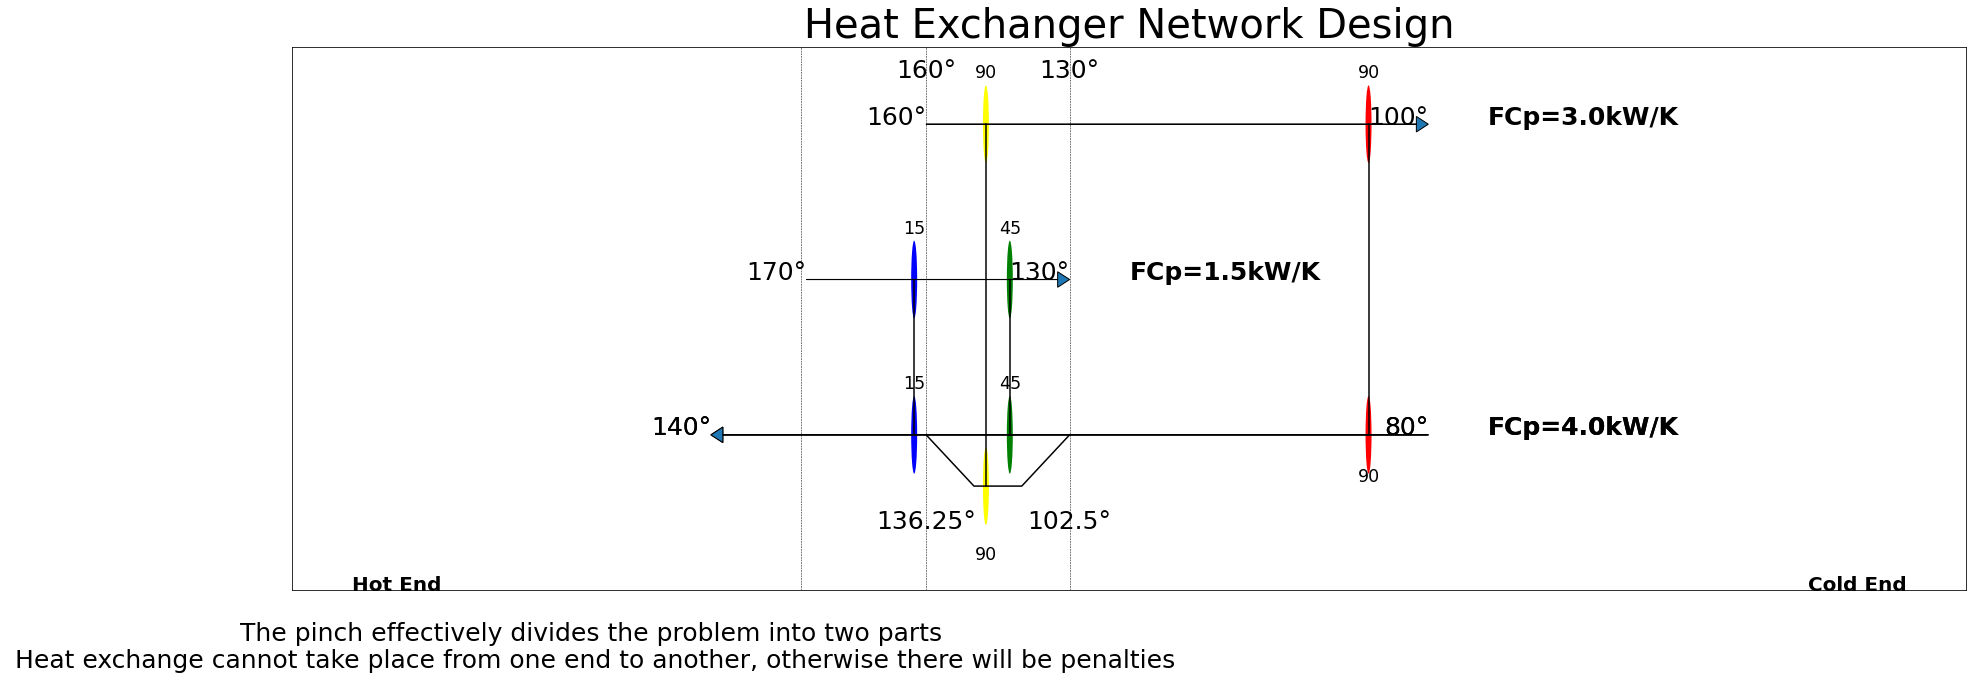

In [43]:
Final_Heat_Exchanger_Network()

In [41]:

#see the other jupyter notebook
#explain so that a lame man can also understand